# Predictive Model for SCA Score - Washed Fermentation Process

In [99]:
#!pip install scikit-learn

#!pip install xgboost


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/53/7d/dc4fda290282be0fb45efd4e9ee5bdc225b5690d0f53048a94ec028b6a3b/xgboost-2.1.0-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


## 1. Import library

In [3]:
import sys
assert sys.version_info >= (3, 7)
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats
from matplotlib.ticker import MaxNLocator, PercentFormatter

## 2. Import Dataset

In [4]:
# If you are running the code on the cloud like Colab, please make sure you have upload the csv "fake_main_data.csv" file in the cloud folder
df = pd.read_csv("fake_main_data.csv")

# If you are running the code on your local compture, please replace the below file path to your own file path
#df=pd.read_csv("/Users/yuyichen/Desktop/Summer 2024/Community Project/fake_main_data.csv")

In [5]:
df.head

<bound method NDFrame.head of         Batch ID  Batch Name Coffee Variety Harvest Date Fermentation Method  \
0        Batch 1     Batch 1        Special   10/25/2023               Honey   
1        Batch 2     Batch 2        Special   05/28/2023               Honey   
2        Batch 3     Batch 3        Special   08/26/2022              Washed   
3        Batch 4     Batch 4        Special   06/09/2024               Honey   
4        Batch 5     Batch 5        Special   05/16/2022               Honey   
...          ...         ...            ...          ...                 ...   
4995  Batch 4996  Batch 4996        Special   04/17/2024              Washed   
4996  Batch 4997  Batch 4997        Special   01/03/2024               Honey   
4997  Batch 4998  Batch 4998         Normal   10/31/2022               Honey   
4998  Batch 4999  Batch 4999        Special   09/14/2021               Honey   
4999  Batch 5000  Batch 5000         Normal   12/14/2021               Honey   

     Type

In [6]:
df.dtypes

Batch ID                                      object
Batch Name                                    object
Coffee Variety                                object
Harvest Date                                  object
Fermentation Method                           object
Type of Water Used                            object
Additives for fermentation                    object
SCA Score                                      int64
Fermentation Records                          object
Average Temp                                 float64
Average PH                                   float64
Average Brix                                 float64
Average Humidity                               int64
Fermentation Weather                          object
Fermentation Start                            object
Fermentation End                              object
Drying Records                                object
Drying Start Date/Time                        object
Drying End Date/Time                          

In [7]:
df.shape

(5000, 27)

In [35]:
# Check any null values of the df
df.isnull().sum()

Batch ID                                        0
Batch Name                                      0
Coffee Variety                                  0
Harvest Date                                    0
Fermentation Method                             0
Type of Water Used                           2507
Additives for fermentation                   3957
SCA Score                                       0
Fermentation Records                            0
Average Temp                                    0
Average PH                                      0
Average Brix                                    0
Average Humidity                                0
Fermentation Weather                            0
Fermentation Start                              0
Fermentation End                                0
Drying Records                                  0
Drying Start Date/Time                          0
Drying End Date/Time                            0
Form Submitted Date/Time                        0


In [9]:
df

,Batch ID,Batch Name,Coffee Variety,Harvest Date,Fermentation Method,Type of Water Used,Additives for fermentation,SCA Score,Fermentation Records,Average Temp,...,Drying Start Date/Time,Drying End Date/Time,Form Submitted Date/Time,Form Modified Date/Time,Average Drying Temp,Average Drying Humidity,Barrel Open in (Hour),Barrel Close in (Hour),Pre-fermentation for Honey,Pre-fermentation Details (Hour) for Honey
0,Batch 1,Batch 1,Special,10/25/2023,Honey,NaN,NaN,90,"ferm_Batch 1_2023-10-20T14:50:24.709898,ferm_B...",22.5,...,10/26/2023 06:54 AM,10/30/2023 11:54 AM,10/20/2023 02:11 PM,10/25/2023 10:02 PM,28.0,67.885,1.0,78.0,No,0.0
1,Batch 2,Batch 2,Special,05/28/2023,Honey,NaN,Yeast,87,"ferm_Batch 2_2023-05-24T13:21:13.816306,ferm_B...",26.8,...,05/28/2023 04:50 AM,06/01/2023 06:50 PM,05/23/2023 07:15 PM,05/28/2023 01:52 PM,27.7,82.335,0.0,105.0,No,0.0
2,Batch 3,Batch 3,Special,08/26/2022,Washed,Filtered Water,NaN,85,"ferm_Batch 3_2022-08-23T19:47:31.873000,ferm_B...",23.9,...,08/26/2022 07:40 PM,08/30/2022 02:40 PM,08/21/2022 09:32 AM,08/26/2022 12:11 PM,23.5,70.137,NaN,NaN,NaN,NaN
3,Batch 4,Batch 4,Special,06/09/2024,Honey,NaN,NaN,84,"ferm_Batch 4_2024-06-06T20:30:21.993883,ferm_B...",21.7,...,06/09/2024 12:44 PM,06/14/2024 09:44 AM,06/06/2024 12:15 AM,06/09/2024 11:41 AM,21.9,67.560,1.0,100.0,No,0.0
4,Batch 5,Batch 5,Special,05/16/2022,Honey,NaN,Yeast,90,"ferm_Batch 5_2022-05-12T16:54:36.763953,ferm_B...",28.0,...,05/16/2022 11:35 PM,05/21/2022 01:35 AM,05/10/2022 11:57 PM,05/16/2022 10:16 PM,18.0,62.027,1.0,73.0,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Batch 4996,Batch 4996,Special,04/17/2024,Washed,Spring Water,NaN,86,"ferm_Batch 4996_2024-04-15T21:36:47.786786,fer...",26.9,...,04/17/2024 09:17 PM,04/21/2024 03:17 PM,04/12/2024 03:34 PM,04/18/2024 12:01 AM,19.2,72.929,NaN,NaN,NaN,NaN
4996,Batch 4997,Batch 4997,Special,01/03/2024,Honey,NaN,NaN,88,"ferm_Batch 4997_2024-01-01T17:59:10.088022,fer...",26.0,...,01/04/2024 06:47 AM,01/08/2024 06:47 PM,12/31/2023 07:36 AM,01/04/2024 03:48 AM,28.0,83.538,0.0,65.0,Yes,16.0
4997,Batch 4998,Batch 4998,Normal,10/31/2022,Honey,NaN,NaN,84,"ferm_Batch 4998_2022-10-28T22:15:47.185885,fer...",21.0,...,10/31/2022 10:28 AM,11/05/2022 01:28 PM,10/27/2022 02:20 PM,10/31/2022 07:37 AM,24.0,63.423,2.0,100.0,No,0.0
4998,Batch 4999,Batch 4999,Special,09/14/2021,Honey,NaN,NaN,88,"ferm_Batch 4999_2021-09-11T16:46:49.098783,fer...",21.6,...,09/14/2021 11:34 PM,09/20/2021 03:34 AM,09/09/2021 09:43 AM,09/14/2021 04:58 PM,18.1,78.858,3.0,87.0,No,0.0


## 3. EDA

### Data Cleaning
#### Filter the dataframe for only Washed Fermentation

In [10]:
# Filter the dataframe by 'Fermentation Method' with value 'Washed'
df_washed = df[df['Fermentation Method'] == 'Washed']
df_washed

,Batch ID,Batch Name,Coffee Variety,Harvest Date,Fermentation Method,Type of Water Used,Additives for fermentation,SCA Score,Fermentation Records,Average Temp,...,Drying Start Date/Time,Drying End Date/Time,Form Submitted Date/Time,Form Modified Date/Time,Average Drying Temp,Average Drying Humidity,Barrel Open in (Hour),Barrel Close in (Hour),Pre-fermentation for Honey,Pre-fermentation Details (Hour) for Honey
2,Batch 3,Batch 3,Special,08/26/2022,Washed,Filtered Water,NaN,85,"ferm_Batch 3_2022-08-23T19:47:31.873000,ferm_B...",23.9,...,08/26/2022 07:40 PM,08/30/2022 02:40 PM,08/21/2022 09:32 AM,08/26/2022 12:11 PM,23.5,70.137,NaN,NaN,NaN,NaN
5,Batch 6,Batch 6,Special,12/22/2021,Washed,Spring Water,NaN,82,"ferm_Batch 6_2021-12-18T07:12:34.610227,ferm_B...",18.0,...,12/22/2021 11:00 AM,12/27/2021 03:00 PM,12/17/2021 03:29 AM,12/22/2021 09:14 AM,18.6,70.695,NaN,NaN,NaN,NaN
7,Batch 8,Batch 8,Special,02/06/2023,Washed,Spring Water,Molasses,84,"ferm_Batch 8_2023-02-05T21:59:46.820209,ferm_B...",21.8,...,02/06/2023 06:55 AM,02/10/2023 10:55 PM,02/03/2023 01:48 PM,02/06/2023 05:17 AM,22.5,81.646,NaN,NaN,NaN,NaN
11,Batch 12,Batch 12,Special,07/02/2022,Washed,Spring Water,NaN,84,"ferm_Batch 12_2022-07-02T06:51:12.042083,ferm_...",19.2,...,07/02/2022 09:31 PM,07/08/2022 02:31 AM,06/27/2022 04:59 PM,07/02/2022 09:56 PM,26.7,90.000,NaN,NaN,NaN,NaN
12,Batch 13,Batch 13,Special,05/22/2024,Washed,Spring Water,NaN,85,"ferm_Batch 13_2024-05-19T04:25:14.137728,ferm_...",27.4,...,05/22/2024 11:25 PM,05/27/2024 11:25 AM,05/19/2024 01:20 AM,05/22/2024 11:14 PM,20.9,90.000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,Batch 4988,Batch 4988,Normal,04/26/2023,Washed,Spring Water,Sugar,85,"ferm_Batch 4988_2023-04-22T12:34:59.984028,fer...",23.7,...,04/26/2023 07:36 PM,05/02/2023 04:36 PM,04/21/2023 07:14 AM,04/26/2023 05:15 PM,20.4,60.231,NaN,NaN,NaN,NaN
4989,Batch 4990,Batch 4990,Normal,01/26/2024,Washed,Spring Water,NaN,83,"ferm_Batch 4990_2024-01-25T15:02:05.062050,fer...",23.2,...,01/26/2024 02:04 PM,01/30/2024 09:04 AM,01/22/2024 10:29 PM,01/26/2024 02:02 PM,23.8,72.122,NaN,NaN,NaN,NaN
4992,Batch 4993,Batch 4993,Special,01/18/2023,Washed,Well Water,Honey,86,"ferm_Batch 4993_2023-01-13T00:09:43.163260,fer...",24.0,...,01/18/2023 01:00 AM,01/22/2023 06:00 PM,01/12/2023 10:02 PM,01/18/2023 10:34 AM,19.5,88.017,NaN,NaN,NaN,NaN
4994,Batch 4995,Batch 4995,Special,11/07/2023,Washed,Well Water,NaN,84,"ferm_Batch 4995_2023-11-06T10:22:30.811276,fer...",22.8,...,11/07/2023 04:36 PM,11/10/2023 08:36 PM,11/02/2023 10:23 PM,11/07/2023 01:41 PM,28.0,74.696,NaN,NaN,NaN,NaN


#### Drop Columns that are Recorded for Honey Fermentation

In [11]:
df_washed = df_washed.drop([ 'Barrel Open in (Hour)', 'Barrel Close in (Hour)', 'Pre-fermentation for Honey', 'Pre-fermentation Details (Hour) for Honey'],  axis=1)
df_washed

,Batch ID,Batch Name,Coffee Variety,Harvest Date,Fermentation Method,Type of Water Used,Additives for fermentation,SCA Score,Fermentation Records,Average Temp,...,Fermentation Weather,Fermentation Start,Fermentation End,Drying Records,Drying Start Date/Time,Drying End Date/Time,Form Submitted Date/Time,Form Modified Date/Time,Average Drying Temp,Average Drying Humidity
2,Batch 3,Batch 3,Special,08/26/2022,Washed,Filtered Water,NaN,85,"ferm_Batch 3_2022-08-23T19:47:31.873000,ferm_B...",23.9,...,"Overcast,Partly Cloudy,Light Rain,Rainy,Cloudy",08/21/2022 07:40 AM,08/26/2022 07:40 AM,"dry_Batch 3_2022-08-28T09:38:28.873000,dry_Bat...",08/26/2022 07:40 PM,08/30/2022 02:40 PM,08/21/2022 09:32 AM,08/26/2022 12:11 PM,23.5,70.137
5,Batch 6,Batch 6,Special,12/22/2021,Washed,Spring Water,NaN,82,"ferm_Batch 6_2021-12-18T07:12:34.610227,ferm_B...",18.0,...,"Light Rain,Light Rain,Sunny",12/17/2021 03:00 AM,12/22/2021 08:00 AM,"dry_Batch 6_2021-12-26T20:26:19.610227,dry_Bat...",12/22/2021 11:00 AM,12/27/2021 03:00 PM,12/17/2021 03:29 AM,12/22/2021 09:14 AM,18.6,70.695
7,Batch 8,Batch 8,Special,02/06/2023,Washed,Spring Water,Molasses,84,"ferm_Batch 8_2023-02-05T21:59:46.820209,ferm_B...",21.8,...,"Overcast,Cloudy,Cloudy",02/03/2023 02:55 AM,02/06/2023 04:55 AM,"dry_Batch 8_2023-02-10T19:34:11.820209,dry_Bat...",02/06/2023 06:55 AM,02/10/2023 10:55 PM,02/03/2023 01:48 PM,02/06/2023 05:17 AM,22.5,81.646
11,Batch 12,Batch 12,Special,07/02/2022,Washed,Spring Water,NaN,84,"ferm_Batch 12_2022-07-02T06:51:12.042083,ferm_...",19.2,...,"Cloudy,Rainy,Heavy Rain,Partly Cloudy,Light Rain",06/27/2022 08:31 AM,07/02/2022 08:31 PM,"dry_Batch 12_2022-07-05T22:03:53.042083,dry_Ba...",07/02/2022 09:31 PM,07/08/2022 02:31 AM,06/27/2022 04:59 PM,07/02/2022 09:56 PM,26.7,90.000
12,Batch 13,Batch 13,Special,05/22/2024,Washed,Spring Water,NaN,85,"ferm_Batch 13_2024-05-19T04:25:14.137728,ferm_...",27.4,...,"Partly Cloudy,Overcast,Cloudy,Cloudy",05/18/2024 07:25 PM,05/22/2024 02:25 PM,"dry_Batch 13_2024-05-25T20:45:15.137728,dry_Ba...",05/22/2024 11:25 PM,05/27/2024 11:25 AM,05/19/2024 01:20 AM,05/22/2024 11:14 PM,20.9,90.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,Batch 4988,Batch 4988,Normal,04/26/2023,Washed,Spring Water,Sugar,85,"ferm_Batch 4988_2023-04-22T12:34:59.984028,fer...",23.7,...,"Cloudy,Cloudy,Partly Cloudy,Sunny",04/21/2023 04:36 AM,04/26/2023 07:36 AM,"dry_Batch 4988_2023-04-29T18:52:04.984028,dry_...",04/26/2023 07:36 PM,05/02/2023 04:36 PM,04/21/2023 07:14 AM,04/26/2023 05:15 PM,20.4,60.231
4989,Batch 4990,Batch 4990,Normal,01/26/2024,Washed,Spring Water,NaN,83,"ferm_Batch 4990_2024-01-25T15:02:05.062050,fer...",23.2,...,"Cloudy,Cloudy,Light Rain,Cloudy,Cloudy",01/22/2024 10:04 PM,01/26/2024 10:04 AM,"dry_Batch 4990_2024-01-27T05:13:19.062050,dry_...",01/26/2024 02:04 PM,01/30/2024 09:04 AM,01/22/2024 10:29 PM,01/26/2024 02:02 PM,23.8,72.122
4992,Batch 4993,Batch 4993,Special,01/18/2023,Washed,Well Water,Honey,86,"ferm_Batch 4993_2023-01-13T00:09:43.163260,fer...",24.0,...,"Cloudy,Partly Cloudy,Sunny",01/12/2023 02:00 PM,01/18/2023 12:00 AM,"dry_Batch 4993_2023-01-22T02:44:54.163260,dry_...",01/18/2023 01:00 AM,01/22/2023 06:00 PM,01/12/2023 10:02 PM,01/18/2023 10:34 AM,19.5,88.017
4994,Batch 4995,Batch 4995,Special,11/07/2023,Washed,Well Water,NaN,84,"ferm_Batch 4995_2023-11-06T10:22:30.811276,fer...",22.8,...,"Cloudy,Cloudy,Partly Cloudy",11/02/2023 04:36 PM,11/07/2023 12:36 PM,"dry_Batch 4995_2023-11-09T21:39:11.811276,dry_...",11/07/2023 04:36 PM,11/10/2023 08:36 PM,11/02/2023 10:23 PM,11/07/2023 01:41 PM,28.0,74.696


### Calcluate the Duration of Each Fermentation Process

In [12]:
# Convert date columns to datetime
df_washed['Fermentation Start'] = pd.to_datetime(df_washed['Fermentation Start'])
df_washed['Fermentation End'] = pd.to_datetime(df_washed['Fermentation End'])

# Calculate the duration of the fermentation process in hours
df_washed['Fermentation Duration (hours)'] = (df_washed['Fermentation End'] - df_washed['Fermentation Start']).dt.total_seconds() / 3600

df_washed

,Batch ID,Batch Name,Coffee Variety,Harvest Date,Fermentation Method,Type of Water Used,Additives for fermentation,SCA Score,Fermentation Records,Average Temp,...,Fermentation Start,Fermentation End,Drying Records,Drying Start Date/Time,Drying End Date/Time,Form Submitted Date/Time,Form Modified Date/Time,Average Drying Temp,Average Drying Humidity,Fermentation Duration (hours)
2,Batch 3,Batch 3,Special,08/26/2022,Washed,Filtered Water,NaN,85,"ferm_Batch 3_2022-08-23T19:47:31.873000,ferm_B...",23.9,...,2022-08-21 07:40:00,2022-08-26 07:40:00,"dry_Batch 3_2022-08-28T09:38:28.873000,dry_Bat...",08/26/2022 07:40 PM,08/30/2022 02:40 PM,08/21/2022 09:32 AM,08/26/2022 12:11 PM,23.5,70.137,120.0
5,Batch 6,Batch 6,Special,12/22/2021,Washed,Spring Water,NaN,82,"ferm_Batch 6_2021-12-18T07:12:34.610227,ferm_B...",18.0,...,2021-12-17 03:00:00,2021-12-22 08:00:00,"dry_Batch 6_2021-12-26T20:26:19.610227,dry_Bat...",12/22/2021 11:00 AM,12/27/2021 03:00 PM,12/17/2021 03:29 AM,12/22/2021 09:14 AM,18.6,70.695,125.0
7,Batch 8,Batch 8,Special,02/06/2023,Washed,Spring Water,Molasses,84,"ferm_Batch 8_2023-02-05T21:59:46.820209,ferm_B...",21.8,...,2023-02-03 02:55:00,2023-02-06 04:55:00,"dry_Batch 8_2023-02-10T19:34:11.820209,dry_Bat...",02/06/2023 06:55 AM,02/10/2023 10:55 PM,02/03/2023 01:48 PM,02/06/2023 05:17 AM,22.5,81.646,74.0
11,Batch 12,Batch 12,Special,07/02/2022,Washed,Spring Water,NaN,84,"ferm_Batch 12_2022-07-02T06:51:12.042083,ferm_...",19.2,...,2022-06-27 08:31:00,2022-07-02 20:31:00,"dry_Batch 12_2022-07-05T22:03:53.042083,dry_Ba...",07/02/2022 09:31 PM,07/08/2022 02:31 AM,06/27/2022 04:59 PM,07/02/2022 09:56 PM,26.7,90.000,132.0
12,Batch 13,Batch 13,Special,05/22/2024,Washed,Spring Water,NaN,85,"ferm_Batch 13_2024-05-19T04:25:14.137728,ferm_...",27.4,...,2024-05-18 19:25:00,2024-05-22 14:25:00,"dry_Batch 13_2024-05-25T20:45:15.137728,dry_Ba...",05/22/2024 11:25 PM,05/27/2024 11:25 AM,05/19/2024 01:20 AM,05/22/2024 11:14 PM,20.9,90.000,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,Batch 4988,Batch 4988,Normal,04/26/2023,Washed,Spring Water,Sugar,85,"ferm_Batch 4988_2023-04-22T12:34:59.984028,fer...",23.7,...,2023-04-21 04:36:00,2023-04-26 07:36:00,"dry_Batch 4988_2023-04-29T18:52:04.984028,dry_...",04/26/2023 07:36 PM,05/02/2023 04:36 PM,04/21/2023 07:14 AM,04/26/2023 05:15 PM,20.4,60.231,123.0
4989,Batch 4990,Batch 4990,Normal,01/26/2024,Washed,Spring Water,NaN,83,"ferm_Batch 4990_2024-01-25T15:02:05.062050,fer...",23.2,...,2024-01-22 22:04:00,2024-01-26 10:04:00,"dry_Batch 4990_2024-01-27T05:13:19.062050,dry_...",01/26/2024 02:04 PM,01/30/2024 09:04 AM,01/22/2024 10:29 PM,01/26/2024 02:02 PM,23.8,72.122,84.0
4992,Batch 4993,Batch 4993,Special,01/18/2023,Washed,Well Water,Honey,86,"ferm_Batch 4993_2023-01-13T00:09:43.163260,fer...",24.0,...,2023-01-12 14:00:00,2023-01-18 00:00:00,"dry_Batch 4993_2023-01-22T02:44:54.163260,dry_...",01/18/2023 01:00 AM,01/22/2023 06:00 PM,01/12/2023 10:02 PM,01/18/2023 10:34 AM,19.5,88.017,130.0
4994,Batch 4995,Batch 4995,Special,11/07/2023,Washed,Well Water,NaN,84,"ferm_Batch 4995_2023-11-06T10:22:30.811276,fer...",22.8,...,2023-11-02 16:36:00,2023-11-07 12:36:00,"dry_Batch 4995_2023-11-09T21:39:11.811276,dry_...",11/07/2023 04:36 PM,11/10/2023 08:36 PM,11/02/2023 10:23 PM,11/07/2023 01:41 PM,28.0,74.696,116.0


### Calcluate the Duration of Each Drying Process

In [13]:
# Convert date columns to datetime
df_washed['Drying Start Date/Time'] = pd.to_datetime(df_washed['Drying Start Date/Time'])
df_washed['Drying End Date/Time'] = pd.to_datetime(df_washed['Drying End Date/Time'])

# Calculate the duration of the fermentation process in hours
df_washed['Drying Fermentation Duration (hours)'] = (df_washed['Drying End Date/Time'] - df_washed['Drying Start Date/Time']).dt.total_seconds() / 3600

df_washed

/var/folders/lb/p0p35dxd4ssf0m7v4xzcmwxm0000gn/T/ipykernel_46521/3404971614.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_washed['Drying Start Date/Time'] = pd.to_datetime(df_washed['Drying Start Date/Time'])
/var/folders/lb/p0p35dxd4ssf0m7v4xzcmwxm0000gn/T/ipykernel_46521/3404971614.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_washed['Drying End Date/Time'] = pd.to_datetime(df_washed['Drying End Date/Time'])


,Batch ID,Batch Name,Coffee Variety,Harvest Date,Fermentation Method,Type of Water Used,Additives for fermentation,SCA Score,Fermentation Records,Average Temp,...,Fermentation End,Drying Records,Drying Start Date/Time,Drying End Date/Time,Form Submitted Date/Time,Form Modified Date/Time,Average Drying Temp,Average Drying Humidity,Fermentation Duration (hours),Drying Fermentation Duration (hours)
2,Batch 3,Batch 3,Special,08/26/2022,Washed,Filtered Water,NaN,85,"ferm_Batch 3_2022-08-23T19:47:31.873000,ferm_B...",23.9,...,2022-08-26 07:40:00,"dry_Batch 3_2022-08-28T09:38:28.873000,dry_Bat...",2022-08-26 19:40:00,2022-08-30 14:40:00,08/21/2022 09:32 AM,08/26/2022 12:11 PM,23.5,70.137,120.0,91.0
5,Batch 6,Batch 6,Special,12/22/2021,Washed,Spring Water,NaN,82,"ferm_Batch 6_2021-12-18T07:12:34.610227,ferm_B...",18.0,...,2021-12-22 08:00:00,"dry_Batch 6_2021-12-26T20:26:19.610227,dry_Bat...",2021-12-22 11:00:00,2021-12-27 15:00:00,12/17/2021 03:29 AM,12/22/2021 09:14 AM,18.6,70.695,125.0,124.0
7,Batch 8,Batch 8,Special,02/06/2023,Washed,Spring Water,Molasses,84,"ferm_Batch 8_2023-02-05T21:59:46.820209,ferm_B...",21.8,...,2023-02-06 04:55:00,"dry_Batch 8_2023-02-10T19:34:11.820209,dry_Bat...",2023-02-06 06:55:00,2023-02-10 22:55:00,02/03/2023 01:48 PM,02/06/2023 05:17 AM,22.5,81.646,74.0,112.0
11,Batch 12,Batch 12,Special,07/02/2022,Washed,Spring Water,NaN,84,"ferm_Batch 12_2022-07-02T06:51:12.042083,ferm_...",19.2,...,2022-07-02 20:31:00,"dry_Batch 12_2022-07-05T22:03:53.042083,dry_Ba...",2022-07-02 21:31:00,2022-07-08 02:31:00,06/27/2022 04:59 PM,07/02/2022 09:56 PM,26.7,90.000,132.0,125.0
12,Batch 13,Batch 13,Special,05/22/2024,Washed,Spring Water,NaN,85,"ferm_Batch 13_2024-05-19T04:25:14.137728,ferm_...",27.4,...,2024-05-22 14:25:00,"dry_Batch 13_2024-05-25T20:45:15.137728,dry_Ba...",2024-05-22 23:25:00,2024-05-27 11:25:00,05/19/2024 01:20 AM,05/22/2024 11:14 PM,20.9,90.000,91.0,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,Batch 4988,Batch 4988,Normal,04/26/2023,Washed,Spring Water,Sugar,85,"ferm_Batch 4988_2023-04-22T12:34:59.984028,fer...",23.7,...,2023-04-26 07:36:00,"dry_Batch 4988_2023-04-29T18:52:04.984028,dry_...",2023-04-26 19:36:00,2023-05-02 16:36:00,04/21/2023 07:14 AM,04/26/2023 05:15 PM,20.4,60.231,123.0,141.0
4989,Batch 4990,Batch 4990,Normal,01/26/2024,Washed,Spring Water,NaN,83,"ferm_Batch 4990_2024-01-25T15:02:05.062050,fer...",23.2,...,2024-01-26 10:04:00,"dry_Batch 4990_2024-01-27T05:13:19.062050,dry_...",2024-01-26 14:04:00,2024-01-30 09:04:00,01/22/2024 10:29 PM,01/26/2024 02:02 PM,23.8,72.122,84.0,91.0
4992,Batch 4993,Batch 4993,Special,01/18/2023,Washed,Well Water,Honey,86,"ferm_Batch 4993_2023-01-13T00:09:43.163260,fer...",24.0,...,2023-01-18 00:00:00,"dry_Batch 4993_2023-01-22T02:44:54.163260,dry_...",2023-01-18 01:00:00,2023-01-22 18:00:00,01/12/2023 10:02 PM,01/18/2023 10:34 AM,19.5,88.017,130.0,113.0
4994,Batch 4995,Batch 4995,Special,11/07/2023,Washed,Well Water,NaN,84,"ferm_Batch 4995_2023-11-06T10:22:30.811276,fer...",22.8,...,2023-11-07 12:36:00,"dry_Batch 4995_2023-11-09T21:39:11.811276,dry_...",2023-11-07 16:36:00,2023-11-10 20:36:00,11/02/2023 10:23 PM,11/07/2023 01:41 PM,28.0,74.696,116.0,76.0


In [14]:
weather_conditions_colombia = [
    "Sunny", "Cloudy", "Rainy", "Partly Cloudy", "Overcast", "Light Rain", "Heavy Rain"
]

# Function to count occurrences of each weather condition in a cell
def count_weather_conditions(cell, conditions):
    count_dict = {condition: 0 for condition in conditions}
    if pd.isna(cell):
        return count_dict
    for condition in conditions:
        count_dict[condition] = cell.count(condition)
    return count_dict

# Apply the function to create new columns directly in the dataframe
for condition in weather_conditions_colombia:
    df_washed[condition] = df_washed['Fermentation Weather'].apply(lambda x: x.count(condition) if pd.notna(x) else 0)

# Drop the original 'Fermentation Weather' column
df_washed.drop(columns=['Fermentation Weather'], inplace=True)



In [15]:
df_washed

,Batch ID,Batch Name,Coffee Variety,Harvest Date,Fermentation Method,Type of Water Used,Additives for fermentation,SCA Score,Fermentation Records,Average Temp,...,Average Drying Humidity,Fermentation Duration (hours),Drying Fermentation Duration (hours),Sunny,Cloudy,Rainy,Partly Cloudy,Overcast,Light Rain,Heavy Rain
2,Batch 3,Batch 3,Special,08/26/2022,Washed,Filtered Water,NaN,85,"ferm_Batch 3_2022-08-23T19:47:31.873000,ferm_B...",23.9,...,70.137,120.0,91.0,0,2,1,1,1,1,0
5,Batch 6,Batch 6,Special,12/22/2021,Washed,Spring Water,NaN,82,"ferm_Batch 6_2021-12-18T07:12:34.610227,ferm_B...",18.0,...,70.695,125.0,124.0,1,0,0,0,0,2,0
7,Batch 8,Batch 8,Special,02/06/2023,Washed,Spring Water,Molasses,84,"ferm_Batch 8_2023-02-05T21:59:46.820209,ferm_B...",21.8,...,81.646,74.0,112.0,0,2,0,0,1,0,0
11,Batch 12,Batch 12,Special,07/02/2022,Washed,Spring Water,NaN,84,"ferm_Batch 12_2022-07-02T06:51:12.042083,ferm_...",19.2,...,90.000,132.0,125.0,0,2,1,1,0,1,1
12,Batch 13,Batch 13,Special,05/22/2024,Washed,Spring Water,NaN,85,"ferm_Batch 13_2024-05-19T04:25:14.137728,ferm_...",27.4,...,90.000,91.0,108.0,0,3,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,Batch 4988,Batch 4988,Normal,04/26/2023,Washed,Spring Water,Sugar,85,"ferm_Batch 4988_2023-04-22T12:34:59.984028,fer...",23.7,...,60.231,123.0,141.0,1,3,0,1,0,0,0
4989,Batch 4990,Batch 4990,Normal,01/26/2024,Washed,Spring Water,NaN,83,"ferm_Batch 4990_2024-01-25T15:02:05.062050,fer...",23.2,...,72.122,84.0,91.0,0,4,0,0,0,1,0
4992,Batch 4993,Batch 4993,Special,01/18/2023,Washed,Well Water,Honey,86,"ferm_Batch 4993_2023-01-13T00:09:43.163260,fer...",24.0,...,88.017,130.0,113.0,1,2,0,1,0,0,0
4994,Batch 4995,Batch 4995,Special,11/07/2023,Washed,Well Water,NaN,84,"ferm_Batch 4995_2023-11-06T10:22:30.811276,fer...",22.8,...,74.696,116.0,76.0,0,3,0,1,0,0,0


In [16]:
numerical_columns = ['Average Temp', 'Average PH', 'Average Brix', 'Average Humidity', 'Fermentation Duration (hours)', 'Drying Fermentation Duration (hours)', 
                     'SCA Score',  "Sunny", "Cloudy", "Rainy", "Partly Cloudy", "Overcast", "Light Rain", "Heavy Rain",'Average Drying Temp', 'Average Drying Humidity']
categoric_columns = ['Coffee Variety', 'Type of Water Used', 'Additives for fermentation']

### Correlation Analysis

Correlation Matrix:
                                       Average Temp  Average PH  Average Brix  \
Average Temp                              1.000000   -0.018660     -0.021294   
Average PH                               -0.018660    1.000000      0.034178   
Average Brix                             -0.021294    0.034178      1.000000   
Average Humidity                          0.160853    0.017181     -0.003783   
Fermentation Duration (hours)             0.006008    0.013665     -0.015250   
Drying Fermentation Duration (hours)     -0.013631    0.004187      0.017390   
Sunny                                     0.042793   -0.002184     -0.013631   
Cloudy                                   -0.031792    0.056267     -0.000427   
Rainy                                     0.007148   -0.034266      0.026594   
Partly Cloudy                            -0.018457    0.051172     -0.014044   
Overcast                                 -0.037736   -0.012961      0.001063   
Light Rain         

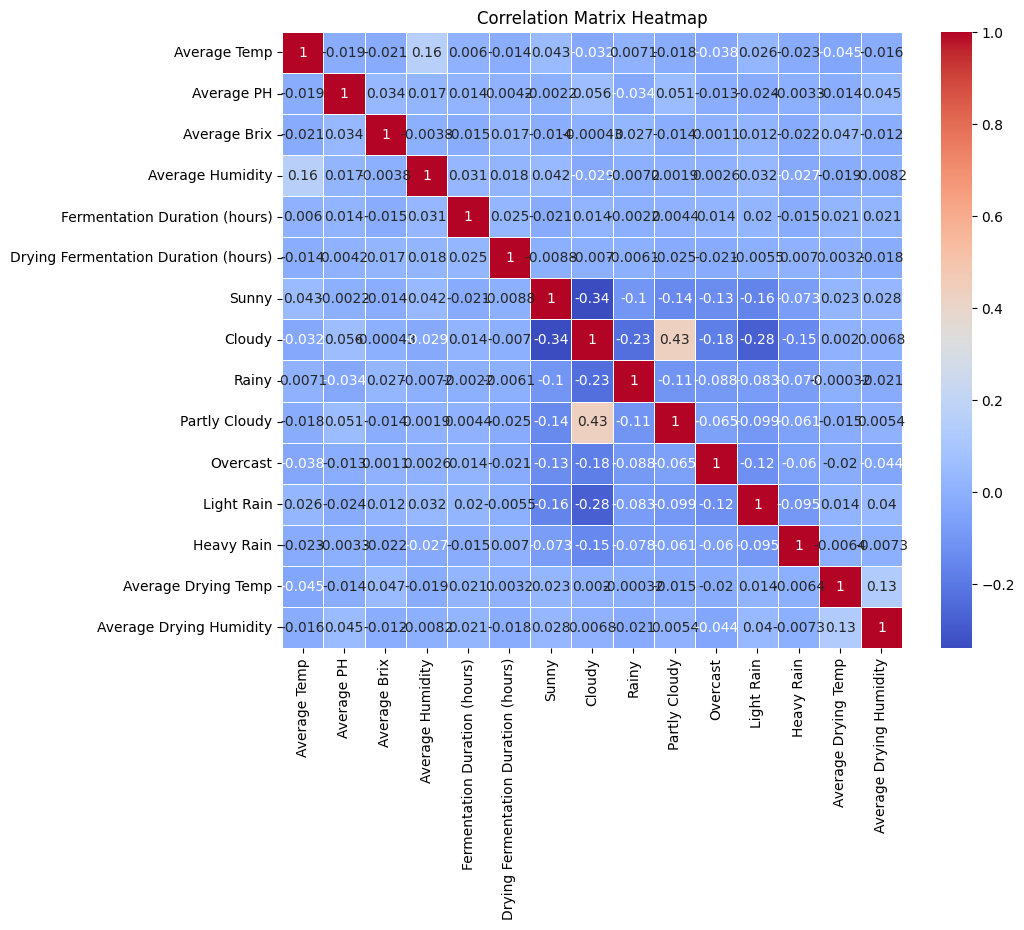

In [17]:

# Calculate correlation matrix for numerical columns
correlation_matrix = df_washed[numerical_columns].corr()

# Remove "SCA Score" from the list of numerical columns
numerical_columns_excluding_sca = [col for col in numerical_columns if col != 'SCA Score']

# Calculate the correlation matrix for numerical columns excluding "SCA Score"
correlation_matrix = df_washed[numerical_columns_excluding_sca].corr()

# Display the correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Univariate Variable Analysis

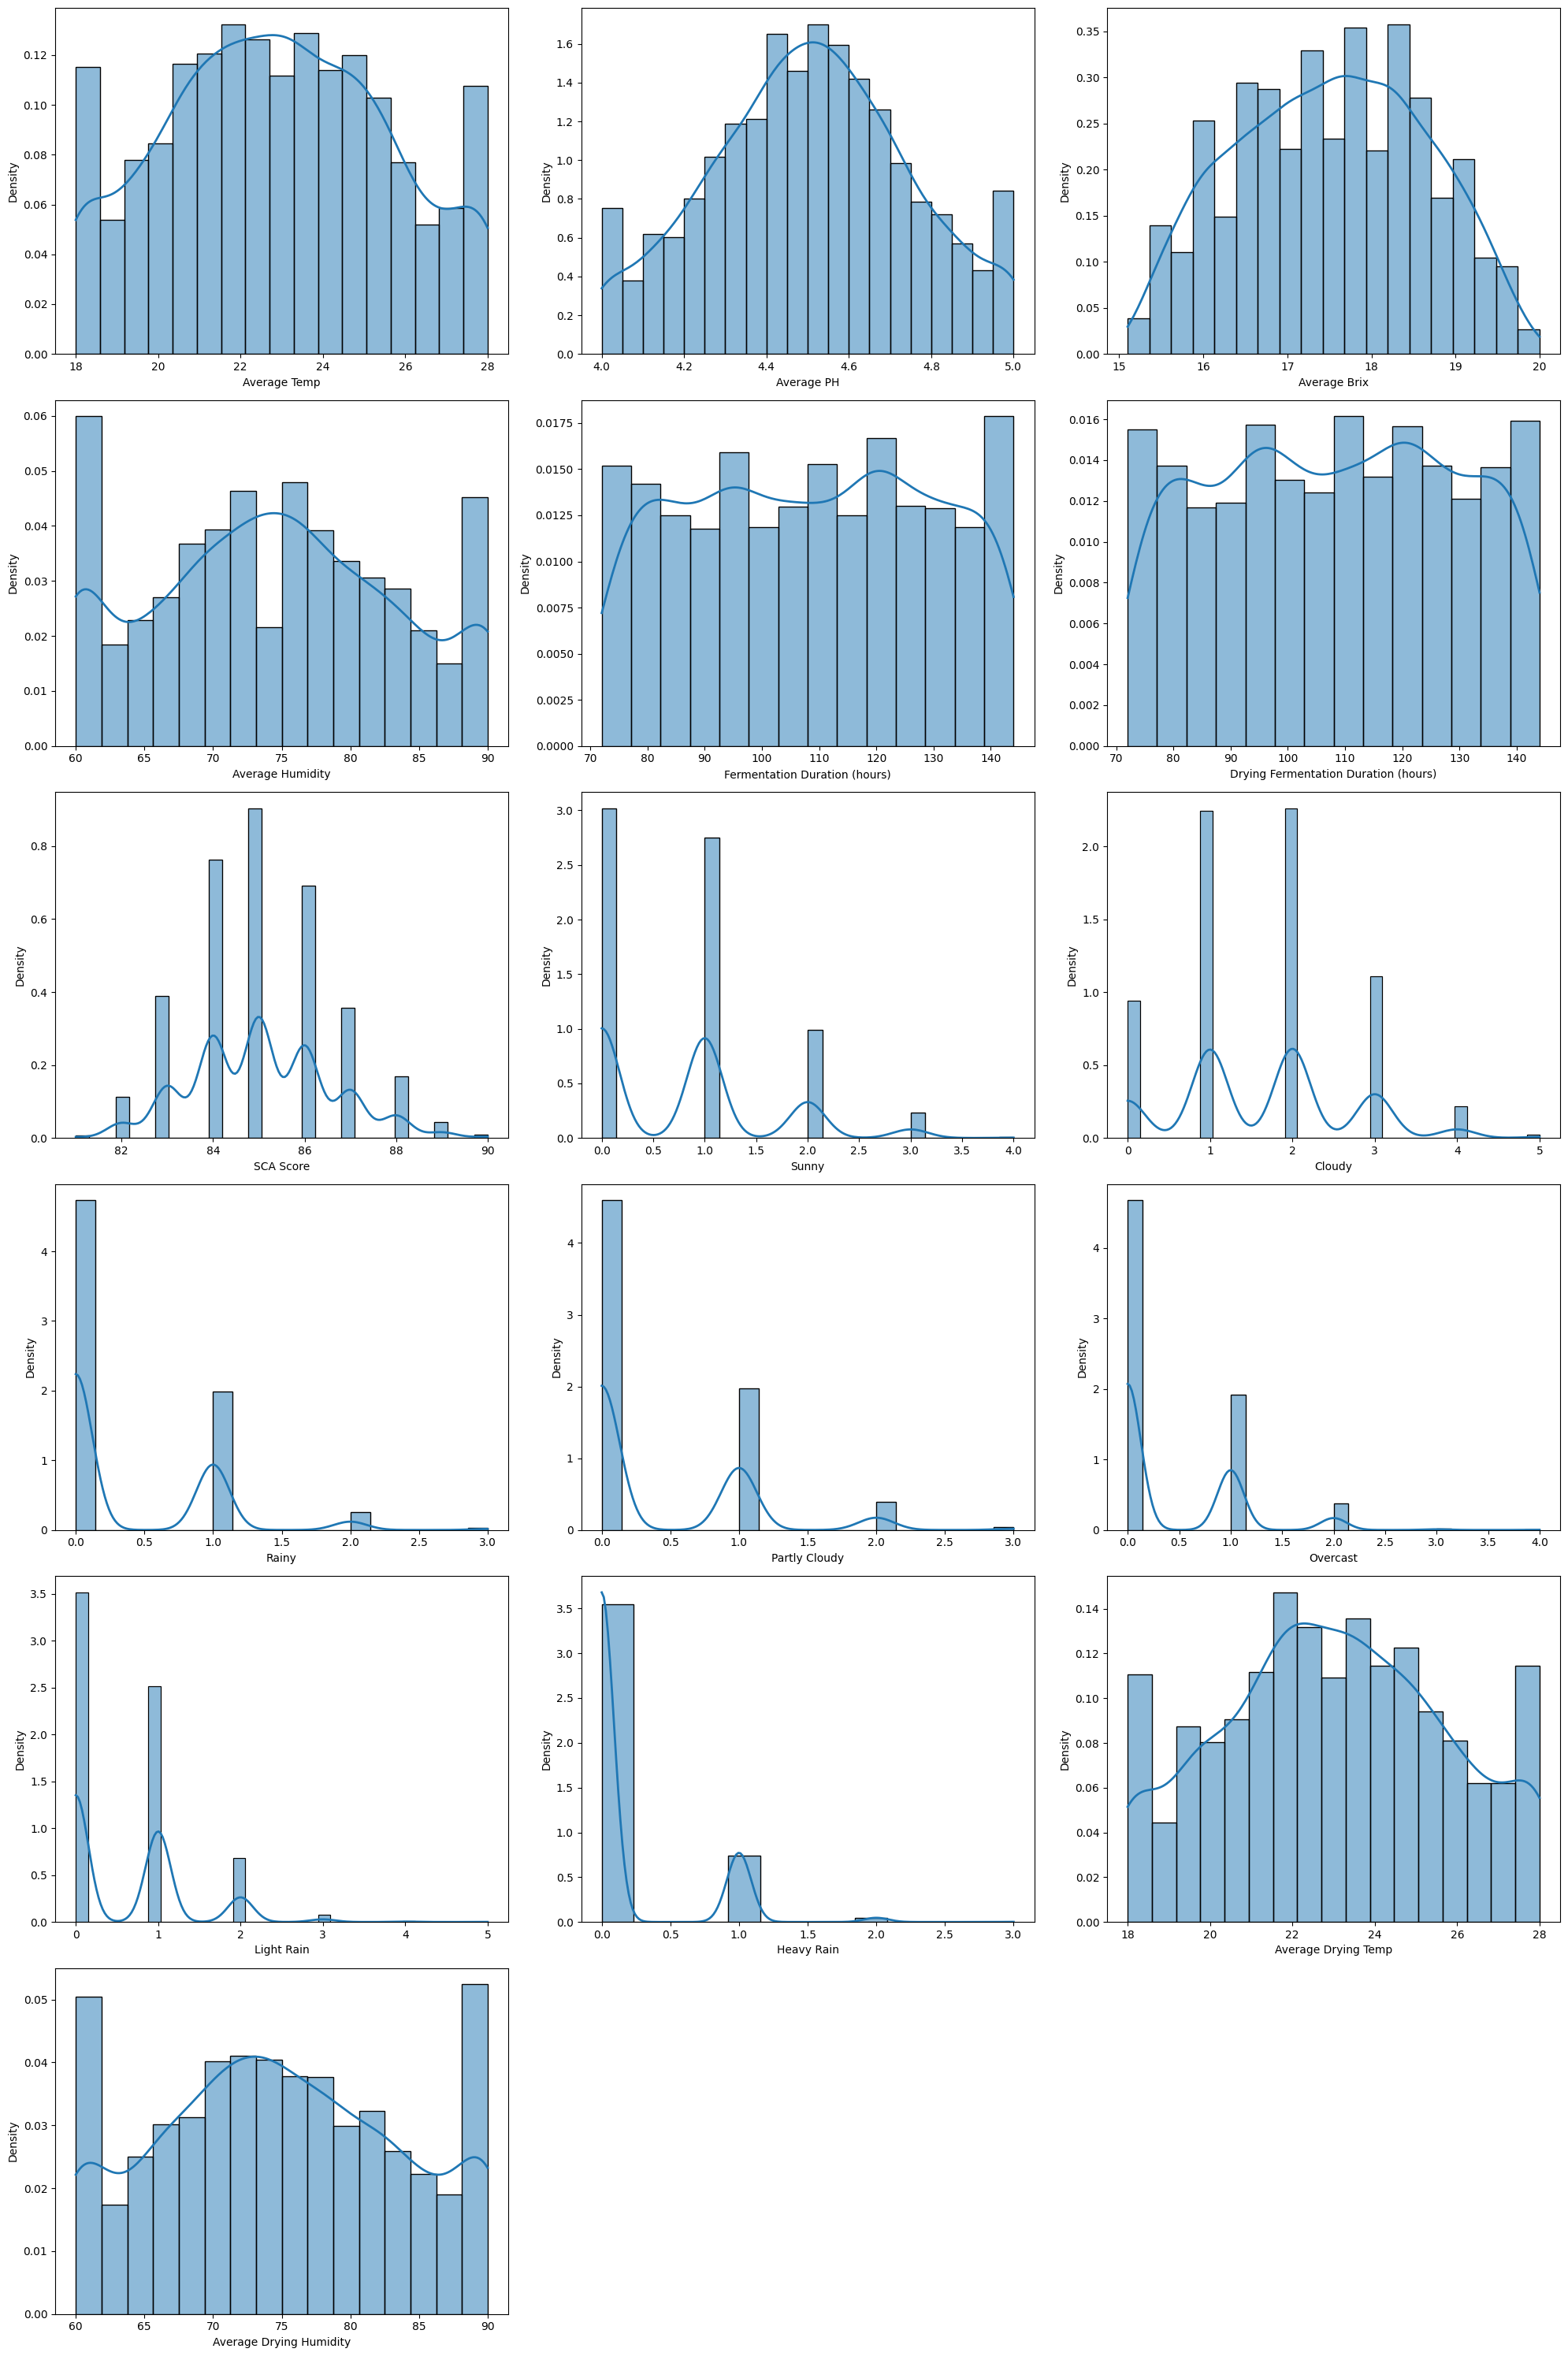

In [18]:
# Calculating the number of rows required in the subplot grid
num_cols = len(numerical_columns)
num_rows = num_cols // 3 + (num_cols % 3 > 0)

# Creating the subplot grid
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Creating histograms with KDE for each numerical column
for i, col in enumerate(numerical_columns):
    sns.histplot(df_washed[col], stat='density', ax=axes[i], kde=True, line_kws={'linewidth': 2})

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Categorical Features

In [19]:
# Check unique values in the 'Additives for fermentation' column
print(df_washed['Additives for fermentation'].unique())

# Ensure 'None' is treated as a valid category
df_washed['Additives for fermentation'] = df['Additives for fermentation'].fillna('None')


[nan 'Molasses' 'Honey' 'Sugar' 'Yeast']


/var/folders/lb/p0p35dxd4ssf0m7v4xzcmwxm0000gn/T/ipykernel_46521/812886025.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_washed[col], ax=axes[i], palette='viridis')  # Using the 'viridis' palette for better distinction
/var/folders/lb/p0p35dxd4ssf0m7v4xzcmwxm0000gn/T/ipykernel_46521/812886025.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_washed[col], ax=axes[i], palette='viridis')  # Using the 'viridis' palette for better distinction
/var/folders/lb/p0p35dxd4ssf0m7v4xzcmwxm0000gn/T/ipykernel_46521/812886025.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `leg

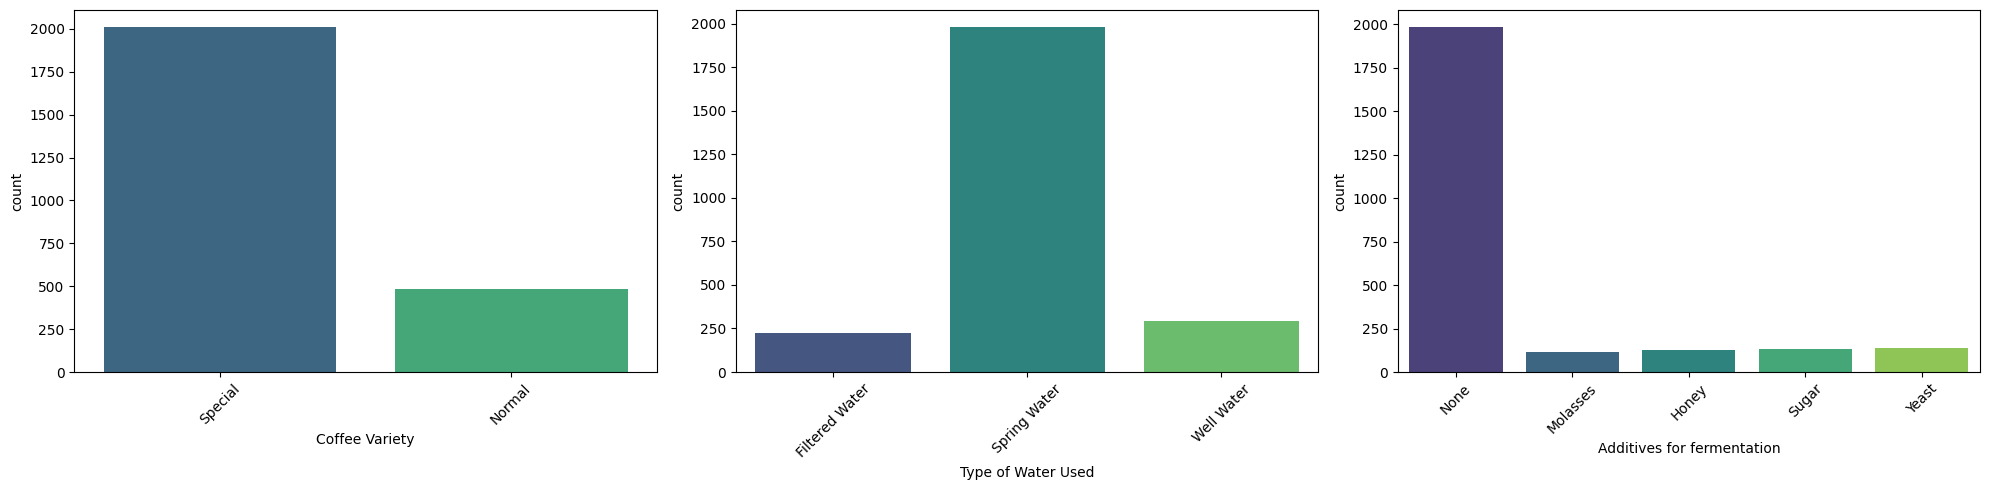

In [20]:
# Calculate the number of rows required in the subplot grid
cnum_cols = len(categoric_columns)
cnum_rows = cnum_cols // 3 + (cnum_cols % 3 > 0)

# Create the subplot grid
fig, axes = plt.subplots(nrows=cnum_rows, ncols=3, figsize=(20, 5 * cnum_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Create bar plots for each categorical column with distinct colors
for i, col in enumerate(categoric_columns):
    sns.countplot(x=df_washed[col], ax=axes[i], palette='viridis')  # Using the 'viridis' palette for better distinction
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Dummified Categorical Columns

In [21]:
# One-hot encode the categorical columns
df_washed = pd.get_dummies(df_washed, columns=categoric_columns, drop_first=True)

# Display the first few rows of the dummified dataset
print(df_washed.head())


    Batch ID Batch Name Harvest Date Fermentation Method  SCA Score  \
2    Batch 3    Batch 3   08/26/2022              Washed         85   
5    Batch 6    Batch 6   12/22/2021              Washed         82   
7    Batch 8    Batch 8   02/06/2023              Washed         84   
11  Batch 12   Batch 12   07/02/2022              Washed         84   
12  Batch 13   Batch 13   05/22/2024              Washed         85   

                                 Fermentation Records  Average Temp  \
2   ferm_Batch 3_2022-08-23T19:47:31.873000,ferm_B...          23.9   
5   ferm_Batch 6_2021-12-18T07:12:34.610227,ferm_B...          18.0   
7   ferm_Batch 8_2023-02-05T21:59:46.820209,ferm_B...          21.8   
11  ferm_Batch 12_2022-07-02T06:51:12.042083,ferm_...          19.2   
12  ferm_Batch 13_2024-05-19T04:25:14.137728,ferm_...          27.4   

    Average PH  Average Brix  Average Humidity  ... Overcast Light Rain  \
2        4.523          15.5                69  ...        1          1

In [22]:
df_washed

,Batch ID,Batch Name,Harvest Date,Fermentation Method,SCA Score,Fermentation Records,Average Temp,Average PH,Average Brix,Average Humidity,...,Overcast,Light Rain,Heavy Rain,Coffee Variety_Special,Type of Water Used_Spring Water,Type of Water Used_Well Water,Additives for fermentation_Molasses,Additives for fermentation_None,Additives for fermentation_Sugar,Additives for fermentation_Yeast
2,Batch 3,Batch 3,08/26/2022,Washed,85,"ferm_Batch 3_2022-08-23T19:47:31.873000,ferm_B...",23.9,4.523,15.5,69,...,1,1,0,True,False,False,False,True,False,False
5,Batch 6,Batch 6,12/22/2021,Washed,82,"ferm_Batch 6_2021-12-18T07:12:34.610227,ferm_B...",18.0,4.329,15.8,68,...,0,2,0,True,True,False,False,True,False,False
7,Batch 8,Batch 8,02/06/2023,Washed,84,"ferm_Batch 8_2023-02-05T21:59:46.820209,ferm_B...",21.8,4.286,17.4,75,...,1,0,0,True,True,False,True,False,False,False
11,Batch 12,Batch 12,07/02/2022,Washed,84,"ferm_Batch 12_2022-07-02T06:51:12.042083,ferm_...",19.2,4.639,17.4,70,...,0,1,1,True,True,False,False,True,False,False
12,Batch 13,Batch 13,05/22/2024,Washed,85,"ferm_Batch 13_2024-05-19T04:25:14.137728,ferm_...",27.4,4.129,16.3,86,...,1,0,0,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,Batch 4988,Batch 4988,04/26/2023,Washed,85,"ferm_Batch 4988_2023-04-22T12:34:59.984028,fer...",23.7,4.373,17.0,75,...,0,0,0,False,True,False,False,False,True,False
4989,Batch 4990,Batch 4990,01/26/2024,Washed,83,"ferm_Batch 4990_2024-01-25T15:02:05.062050,fer...",23.2,4.000,19.3,70,...,0,1,0,False,True,False,False,True,False,False
4992,Batch 4993,Batch 4993,01/18/2023,Washed,86,"ferm_Batch 4993_2023-01-13T00:09:43.163260,fer...",24.0,4.272,16.9,85,...,0,0,0,True,False,True,False,False,False,False
4994,Batch 4995,Batch 4995,11/07/2023,Washed,84,"ferm_Batch 4995_2023-11-06T10:22:30.811276,fer...",22.8,4.297,18.4,60,...,0,0,0,True,False,True,False,True,False,False


### Drop Irrelevant Columns

In [23]:
df_washed = df_washed.drop(['Batch ID', 'Batch Name', 'Harvest Date', 'Fermentation Method', 'Fermentation Records', 'Fermentation Start', 
                            'Fermentation End', 'Drying Records', 'Drying Start Date/Time', 'Drying End Date/Time', 'Form Submitted Date/Time', 'Form Modified Date/Time'],  axis=1)
df_washed

,SCA Score,Average Temp,Average PH,Average Brix,Average Humidity,Average Drying Temp,Average Drying Humidity,Fermentation Duration (hours),Drying Fermentation Duration (hours),Sunny,...,Overcast,Light Rain,Heavy Rain,Coffee Variety_Special,Type of Water Used_Spring Water,Type of Water Used_Well Water,Additives for fermentation_Molasses,Additives for fermentation_None,Additives for fermentation_Sugar,Additives for fermentation_Yeast
2,85,23.9,4.523,15.5,69,23.5,70.137,120.0,91.0,0,...,1,1,0,True,False,False,False,True,False,False
5,82,18.0,4.329,15.8,68,18.6,70.695,125.0,124.0,1,...,0,2,0,True,True,False,False,True,False,False
7,84,21.8,4.286,17.4,75,22.5,81.646,74.0,112.0,0,...,1,0,0,True,True,False,True,False,False,False
11,84,19.2,4.639,17.4,70,26.7,90.000,132.0,125.0,0,...,0,1,1,True,True,False,False,True,False,False
12,85,27.4,4.129,16.3,86,20.9,90.000,91.0,108.0,0,...,1,0,0,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,85,23.7,4.373,17.0,75,20.4,60.231,123.0,141.0,1,...,0,0,0,False,True,False,False,False,True,False
4989,83,23.2,4.000,19.3,70,23.8,72.122,84.0,91.0,0,...,0,1,0,False,True,False,False,True,False,False
4992,86,24.0,4.272,16.9,85,19.5,88.017,130.0,113.0,1,...,0,0,0,True,False,True,False,False,False,False
4994,84,22.8,4.297,18.4,60,28.0,74.696,116.0,76.0,0,...,0,0,0,True,False,True,False,True,False,False


### Feature Importance using Random Forest

Mean Squared Error: 0.41670013368983994
R^2 Score: 0.8023749452419862


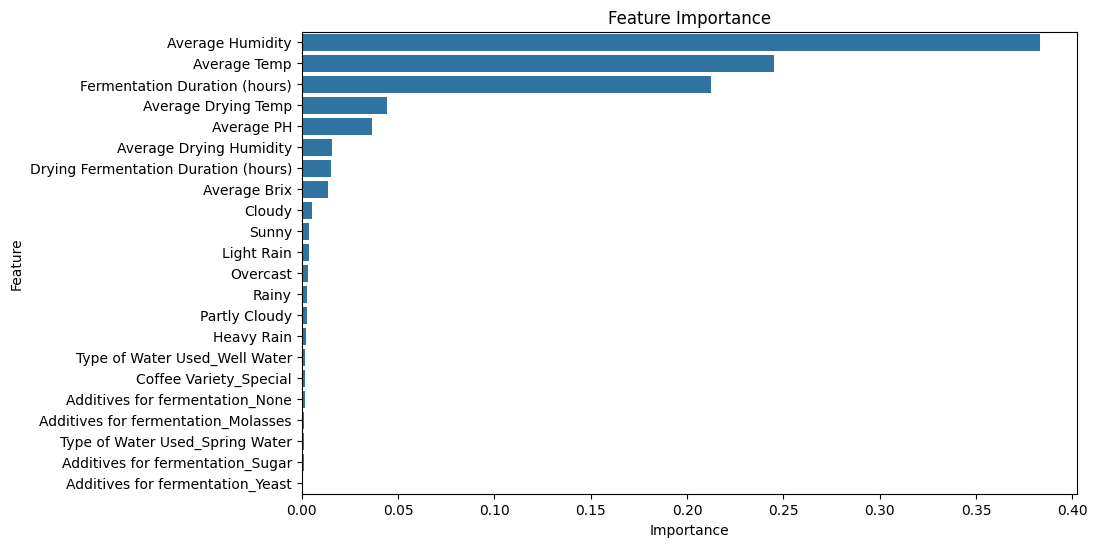

In [24]:

# Define features and target
X = df_washed.drop(columns=['SCA Score'])
y = df_washed['SCA Score'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
importance_df_washed = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the feature importances
importance_df_washed = importance_df_washed.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_washed)
plt.title('Feature Importance')
plt.show()


## 4. Split the Dataset into Training and Testing Sets


In [25]:
# Define features and target
X = df_washed.drop(columns=['SCA Score'])
y = df_washed['SCA Score'] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Training Data with Multiple Models and Evaluating Model Performance

In [26]:


# Function to evaluate the model
def evaluate_model(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Linear Regression
linear_model = LinearRegression()
linear_mse, linear_r2 = evaluate_model(linear_model)

# Ridge Regression
ridge_model = Ridge()
ridge_mse, ridge_r2 = evaluate_model(ridge_model)

# Lasso Regression
lasso_model = Lasso()
lasso_mse, lasso_r2 = evaluate_model(lasso_model)

# Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)
poly_mse = mean_squared_error(y_test, y_pred_poly)
poly_r2 = r2_score(y_test, y_pred_poly)

# Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)
tree_mse, tree_r2 = evaluate_model(tree_model)

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_mse, rf_r2 = evaluate_model(rf_model)

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_mse, gb_r2 = evaluate_model(gb_model)

# XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_mse, xgb_r2 = evaluate_model(xgb_model)

# Support Vector Regression
svr_model = SVR()
svr_mse, svr_r2 = evaluate_model(svr_model)

# Print results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Polynomial Regression',
              'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'SVR'],
    'MSE': [linear_mse, ridge_mse, lasso_mse, poly_mse, tree_mse, rf_mse, gb_mse, xgb_mse, svr_mse],
    'R2': [linear_r2, ridge_r2, lasso_r2, poly_r2, tree_r2, rf_r2, gb_r2, xgb_r2, svr_r2]
})

print(results)

                   Model       MSE        R2
0      Linear Regression  0.416214  0.800992
1       Ridge Regression  0.416162  0.801017
2       Lasso Regression  2.091845 -0.000191
3  Polynomial Regression  0.381721  0.817484
4          Decision Tree  0.817635  0.609057
5          Random Forest  0.401764  0.807901
6      Gradient Boosting  0.368918  0.823606
7                XGBoost  0.458179  0.780927
8                    SVR  0.398287  0.809564


### Plotting the Model Results

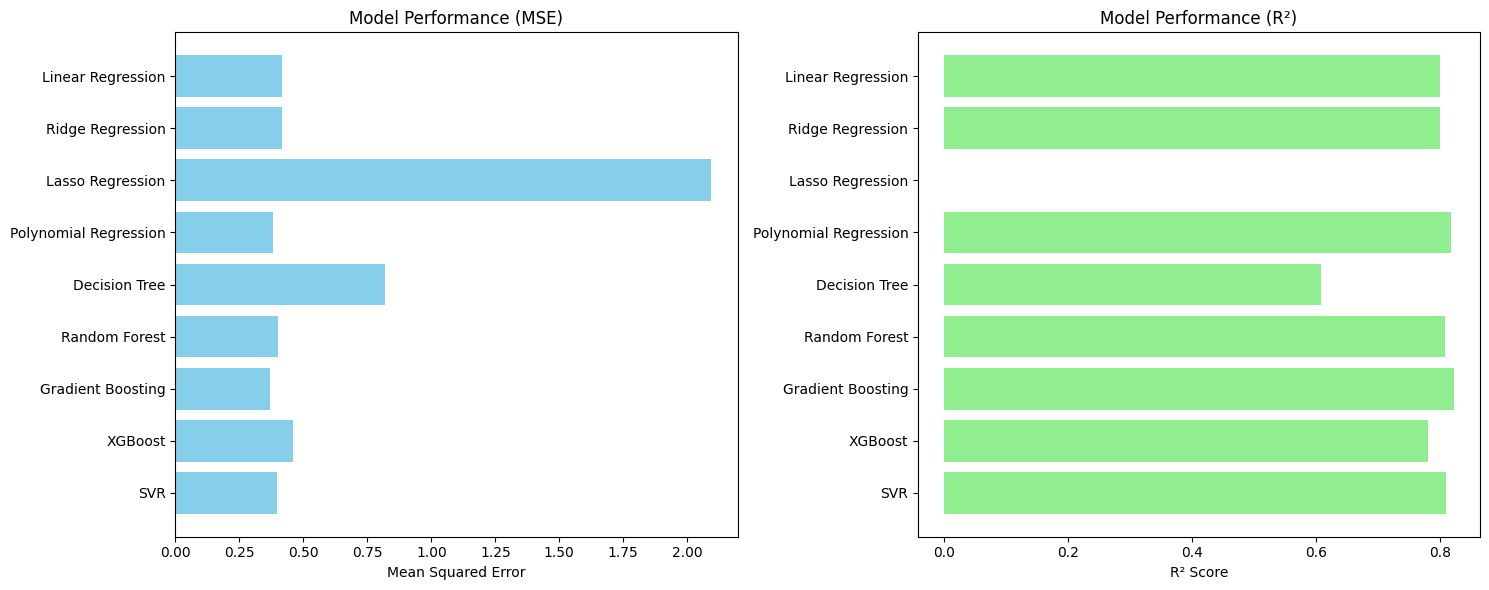

In [27]:
# Updated results data
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Polynomial Regression',
              'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'SVR'],
    'MSE': [linear_mse, ridge_mse, lasso_mse, poly_mse, tree_mse, rf_mse, gb_mse, xgb_mse, svr_mse],
    'R2': [linear_r2, ridge_r2, lasso_r2, poly_r2, tree_r2, rf_r2, gb_r2, xgb_r2, svr_r2]
})


# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# MSE Plot
ax[0].barh(results['Model'], results['MSE'], color='skyblue')
ax[0].set_title('Model Performance (MSE)')
ax[0].set_xlabel('Mean Squared Error')
ax[0].invert_yaxis()

# R2 Plot
ax[1].barh(results['Model'], results['R2'], color='lightgreen')
ax[1].set_title('Model Performance (R²)')
ax[1].set_xlabel('R² Score')
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

### The Best Performed Model - Gradient Boosting

The Gradient Boosting model performs the best among the listed models, with the lowest Mean Squared Error (MSE) and the highest R² score. 
- This indicates that Gradient Boosting is highly effective at capturing the underlying patterns in the data, resulting in accurate predictions with minimal error. 

- The high R² score demonstrates that the model explains a significant portion of the variance in the target variable.

## 6. Hyperparameter Tuning on Gradient Boosting Model

In [28]:
from sklearn.model_selection import GridSearchCV


# Function to evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize the model
xgb_model = XGBRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Initialize the model with the best parameters
best_xgb_model = XGBRegressor(**best_params, random_state=42)

# Evaluate the model
best_xgb_mse, best_xgb_r2 = evaluate_model(best_xgb_model, X_train, X_test, y_train, y_test)

print(f"Best Hyperparameters: {best_params}")
print(f"Best XGBoost MSE: {best_xgb_mse}")
print(f"Best XGBoost R2: {best_xgb_r2}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END 

## 7. Cross Validation

In [29]:
from sklearn.model_selection import cross_val_score

# Define features and target
X = df_washed.drop(columns=['SCA Score'])
y = df_washed['SCA Score'] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model with the best hyperparameters
best_xgb_model = XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

# Perform cross-validation
cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive
cv_mse_scores = -cv_scores

# Calculate the mean and standard deviation of the MSE scores
mean_mse = np.mean(cv_mse_scores)
std_mse = np.std(cv_mse_scores)

# Calculate R^2 scores using cross-validation
cv_r2_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='r2')

# Calculate the mean and standard deviation of the R^2 scores
mean_r2 = np.mean(cv_r2_scores)
std_r2 = np.std(cv_r2_scores)

print(f"Cross-Validated MSE: {mean_mse} ± {std_mse}")
print(f"Cross-Validated R2: {mean_r2} ± {std_r2}")



Cross-Validated MSE: 0.37215455805803666 ± 0.005777824311556927
Cross-Validated R2: 0.8424929857254029 ± 0.008072784972392858


### Observations:

- Mean Squared Error (MSE): The average MSE across the cross-validation folds is 0.37, with a standard deviation of 0.005. This low MSE suggests that the model makes accurate predictions with minimal error. The small standard deviation indicates consistency in the model's performance across different data splits.

- R² Score: The average R² score is 0.842, with a standard deviation of 0.008. This high R² score means that the model explains 84.2% of the variance in the target variable, indicating a very good fit. The low standard deviation further suggests that the model's predictive power is stable across different subsets of the data.

Overall, these results demonstrate that the XGBoost model is both accurate and consistent in predicting the target variable, making it a reliable choice for this dataset.

## 8. Fit the Model and Save it

In [33]:
import joblib

# Define features and target
X = df_washed.drop(columns=['SCA Score'])
y = df_washed['SCA Score'] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model with the best hyperparameters
xgb_model = XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Save the fitted model
joblib.dump(xgb_model, 'xgb_model.pkl')

# Optionally, evaluate the model
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Model MSE: {mse}")
print(f"XGBoost Model R2: {r2}")


XGBoost Model MSE: 0.3456743023692367
XGBoost Model R2: 0.8347198963165283


## 9. Predicting SCA Scores with New Data Using a Trained Model

In [34]:
# Simulate loading the new batch of data into a DataFrame (new_data_df)
new_data = {
    'Average Temp': [24.7, 21.3, 26.7],
    'Average PH': [4.794, 4.639, 4.32],
    'Average Brix': [15.7, 17.4, 19.7],
    'Average Humidity': [77, 69, 74],
    'Average Drying Temp': [22.4, 22.4, 20.9],
    'Average Drying Humidity': [76.591, 71.111, 73.626],
    'Fermentation Duration (hours)': [111, 85, 98],
    'Drying Fermentation Duration (hours)': [114, 100, 90],
    'Sunny': [0, 0, 1],
    'Cloudy': [1, 2, 2],
    'Rainy': [1, 0, 0],
    'Partly Cloudy': [0, 1, 0],
    'Overcast': [0, 0, 0],
    'Light Rain': [2, 1, 1],
    'Heavy Rain': [0, 1, 0],
    'Coffee Variety_Special': [True, True, False],
    'Type of Water Used_Spring Water': [True, True, True],
    'Type of Water Used_Well Water': [False, False, False],
    'Additives for fermentation_Molasses': [False, False, False],
    'Additives for fermentation_None': [True, True, False],
    'Additives for fermentation_Sugar': [False, False, False],
    'Additives for fermentation_Yeast': [False, False, False]
}

new_data_df = pd.DataFrame(new_data)

# Load the saved model
xgb_model = joblib.load('xgb_model.pkl')

# Prepare the input data
input_features = new_data_df  # Directly use the columns from the new data

# Make predictions
predictions = xgb_model.predict(input_features)

# Add predictions to the DataFrame
new_data_df['Predicted SCA Score'] = predictions

# Print out the results for each new data point in the specified format
for index, row in new_data_df.iterrows():
    input_vars = row.drop('Predicted SCA Score').to_dict()
    print(f"Data Point {index + 1}:")
    print(f"Input Variables: {input_vars}")
    print(f"Predicted SCA Score: {row['Predicted SCA Score']}\n")



Data Point 1:
Input Variables: {'Average Temp': 24.7, 'Average PH': 4.794, 'Average Brix': 15.7, 'Average Humidity': 77, 'Average Drying Temp': 22.4, 'Average Drying Humidity': 76.591, 'Fermentation Duration (hours)': 111, 'Drying Fermentation Duration (hours)': 114, 'Sunny': 0, 'Cloudy': 1, 'Rainy': 1, 'Partly Cloudy': 0, 'Overcast': 0, 'Light Rain': 2, 'Heavy Rain': 0, 'Coffee Variety_Special': True, 'Type of Water Used_Spring Water': True, 'Type of Water Used_Well Water': False, 'Additives for fermentation_Molasses': False, 'Additives for fermentation_None': True, 'Additives for fermentation_Sugar': False, 'Additives for fermentation_Yeast': False}
Predicted SCA Score: 86.19609069824219

Data Point 2:
Input Variables: {'Average Temp': 21.3, 'Average PH': 4.639, 'Average Brix': 17.4, 'Average Humidity': 69, 'Average Drying Temp': 22.4, 'Average Drying Humidity': 71.111, 'Fermentation Duration (hours)': 85, 'Drying Fermentation Duration (hours)': 100, 'Sunny': 0, 'Cloudy': 2, 'Rainy':